In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse import hstack
import re
from nltk.stem.porter import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier,XGBRegressor
from tqdm import tqdm
import spacy
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
nlp = spacy.load("en_core_web_lg")

In [3]:
data=pd.read_csv('dataset/train.csv')  #loading data

In [4]:
data.columns

Index(['patient_id', 'name_of_drug', 'use_case_for_drug', 'review_by_patient',
       'effectiveness_rating', 'drug_approved_by_UIC',
       'number_of_times_prescribed', 'base_score'],
      dtype='object')

In [5]:
def preprocess(data):
    # name_of_drug
    
    data.name_of_drug = data.name_of_drug.str.lower().str.replace('/','_').str.replace(' ','_').str.replace('_+','_')
    
    # use_case_for_drug
    def remove_tag_lines(x):
        if re.findall('<.*>',x):
            return 'not available'
        return x
    
    data.use_case_for_drug = data.use_case_for_drug.apply(remove_tag_lines)
    data.use_case_for_drug = data.use_case_for_drug.str.lower().str.replace(' / ','_').str.replace(' ','_').str.replace('-','_')
    
    # review_by_patient
    def decontracted(x):
    # specific
        x = str(x).lower()
        x = re.sub('&#039;',"\'",x)
        x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                               .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                               .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                               .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                               .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                               .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                               .replace("€", " euro ").replace("'ll", " will")
        x = x.replace('/',' ')
        x = re.sub('[\r\n]+',' ',x)
        x = re.sub('[&#;.]+[0-9]*',' ',x)
        x = re.sub('\(.*\)',' ',x)
        x = re.sub('[.!,]','',x)
        x = re.sub('[-,.?!@%^&]',' ',x)
        x = re.sub('\s+',' ',x)
        
        return x.strip()
    data.review_by_patient = data.review_by_patient.apply(lambda x:x.strip()[1:-1]).str.lower()
    data.review_by_patient = data.review_by_patient.apply(decontracted)
    
    
    #drug_approved_by_UIC
    data.drug_approved_by_UIC = data.drug_approved_by_UIC.apply(lambda x:int(x.strip()[-2:])) #taking only year
    

In [6]:
preprocess(data)
data.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
0,206461,valsartan,left_ventricular_dysfunction,it has no side effect i take it in combination...,9,12,27,8.022969
1,95260,guanfacine,adhd,my son is halfway through his fourth week of i...,8,10,192,7.858458
2,92703,lybrel,birth_control,i used to take another oral contraceptive whic...,5,9,17,6.341969
3,35696,buprenorphine_naloxone,opiate_dependence,suboxone has completely turned my life around ...,9,16,37,6.590176
4,155963,cialis,benign_prostatic_hyperplasia,2nd day on 5mg started to work with rock hard ...,2,15,43,6.144782


In [7]:
X_train,X_test,y_train,y_test = train_test_split(data.drop('base_score',axis=1),data.base_score,random_state=20,test_size=0.15)

In [8]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((27340, 7), (4825, 7), (27340,), (4825,))

### name_of_drug

In [9]:
onehot_encoder_name_of_drug = OneHotEncoder(handle_unknown='ignore',min_frequency=5)
name_of_drug = onehot_encoder_name_of_drug.fit_transform(X_train.name_of_drug.values.reshape(-1,1))

In [10]:
name_of_drug.shape

(27340, 856)

### use_case_for_drug

In [11]:
onehot_encoder_use_case_for_drug = OneHotEncoder(handle_unknown='ignore',min_frequency=5)
use_case_for_drug = onehot_encoder_use_case_for_drug.fit_transform(X_train.use_case_for_drug.values.reshape(-1,1))

In [12]:
use_case_for_drug.shape

(27340, 284)

### review_by_patient (tfidf-avg-w2v)

In [13]:
X_train.review_by_patient.values[1000:]

array(['i am 31 and this is my first time taking birth control pills this thing is giving me acne all over my face big ones that i have never seen before because i have never had acne in my life i am extremely tired and sleepy all day but i am loosing weight i will have a talk with my gyn at my next appointmenti want something else but i am stuck between choosing to loose weight or keep getting acnes',
       'i have obessive compulsive disorder which causes a lot of anxiety and depression prozac has improved my quality of life i am now a calm happy person with a great family of my own after being on prozac a year it really helps me focus on the real problems in my life and reaching a resolution instead of just feeling overwhelmed it also greatly increases my energy and focus it does not make me a zombie to emotion but it does prevent me from obsessing and lingering on how things make me feel i still feel sad anger etc but in normal amounts like everyone else aside from very detailed d

In [14]:
#loading glove matrix
glove = {}
f = open('/home/ubuntu/Downloads/CNN_with_textdata/glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove[word] = coefs
f.close()

In [15]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train.review_by_patient.values)
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
reviews = np.zeros((len(X_train),300))
i=0
for review in tqdm(X_train.review_by_patient.values):
    vec=np.zeros((300,))
    idf_final = 0
    for word in review.split(' '):
        try:
            idf = word2tfidf[word]
        except:
            idf = 0
        embedding = glove.get(word)
        if embedding is not None:
            vec+=embedding*idf
            idf_final+=idf
    if idf_final!=0:
        reviews[i]=vec/idf_final
    i+=1

100%|███████████████████████████████████| 27340/27340 [00:09<00:00, 2832.62it/s]


In [20]:
' '.join(['siva','sankar','siva'])

'siva sankar siva'

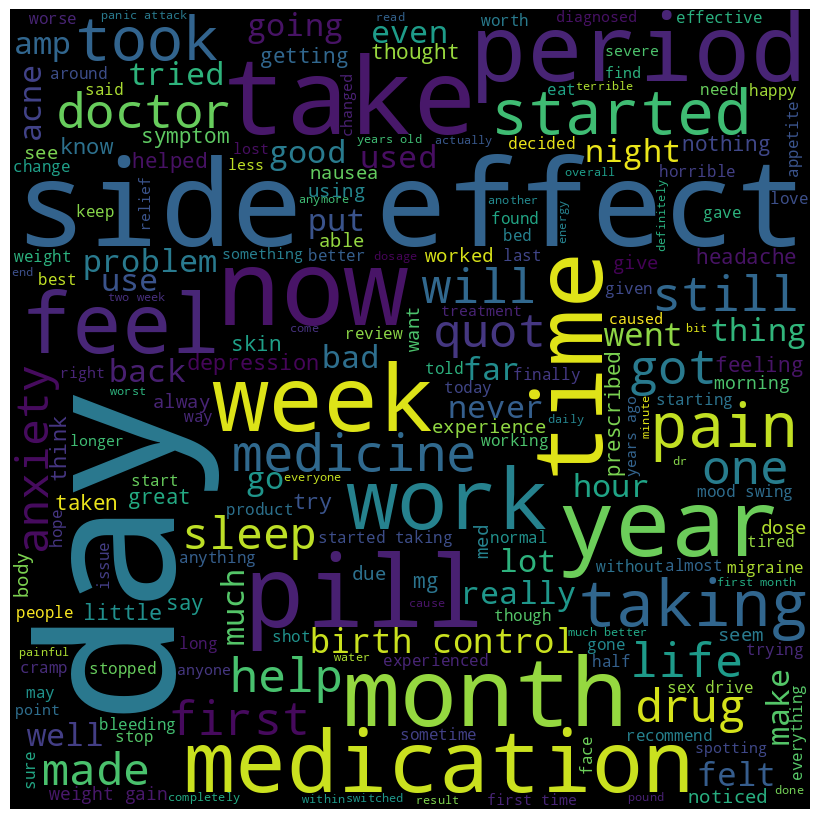

In [24]:
df = reviews
 
comment_words = ' '.join(X_train.review_by_patient.values)
stopwords = set(STOPWORDS)
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### effectiveness_rating

In [91]:
s_effectiveness_rating = StandardScaler()
effectiveness_rating = s_effectiveness_rating.fit_transform(X_train.effectiveness_rating.values.reshape(-1,1))

### drug_approved_by_UIC

In [92]:
s_drug_approved_by_UIC = StandardScaler()
drug_approved_by_UIC = s_drug_approved_by_UIC.fit_transform(X_train.drug_approved_by_UIC.values.reshape(-1,1))

### number_of_times_prescribed

In [93]:
s_number_of_times_prescribed = StandardScaler()
number_of_times_prescribed = s_number_of_times_prescribed.fit_transform(X_train.number_of_times_prescribed.values.reshape(-1,1))

In [94]:
#final 
X_train_final = hstack([name_of_drug,use_case_for_drug,reviews,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed])

In [95]:
def test_feature_process(data):
    f1 = onehot_encoder_name_of_drug.transform(data.name_of_drug.values.reshape(-1,1))
    f2 = onehot_encoder_use_case_for_drug.transform(data.use_case_for_drug.values.reshape(-1,1))
    reviews = np.zeros((len(data),300))
    i=0
    for review in tqdm(data.review_by_patient.values):
        vec=np.zeros((300,))
        idf_final = 0
        for word in review.split(' '):
            try:
                idf = word2tfidf[word]
            except:
                idf = 0
            embedding = glove.get(word)
            if embedding is not None:
                vec+=embedding*idf
                idf_final+=idf
        if idf_final!=0:
             reviews[i]=vec/idf_final
        i+=1
    f3=reviews
    f4 = s_effectiveness_rating.transform(data.effectiveness_rating.values.reshape(-1,1))
    f5 = s_drug_approved_by_UIC.transform(data.drug_approved_by_UIC.values.reshape(-1,1))
    f6 = s_number_of_times_prescribed.transform(data.number_of_times_prescribed.values.reshape(-1,1))
    return hstack([f1,f2,f3,f4,f5,f6])

In [96]:
X_test_final=test_feature_process(X_test)

100%|█████████████████████████████████████| 4825/4825 [00:01<00:00, 2999.17it/s]


In [97]:
X_test_final.shape

(4825, 1443)

In [103]:
paras = {
    'max_depth' :[4,8,10],
    'n_estimators':[20,30,50,100,200],
    'learning_rate':[0.2,0.5,0.1]
}
regres=XGBRegressor(random_state=23)
grid = GridSearchCV(regres,param_grid=paras,scoring='r2',cv=4,verbose=4)
grid.fit(X_train_final,y_train)

Fitting 4 folds for each of 45 candidates, totalling 180 fits
[CV 1/4] END learning_rate=0.2, max_depth=4, n_estimators=20;, score=0.785 total time=   7.6s
[CV 2/4] END learning_rate=0.2, max_depth=4, n_estimators=20;, score=0.771 total time=   7.6s
[CV 3/4] END learning_rate=0.2, max_depth=4, n_estimators=20;, score=0.797 total time=   7.6s
[CV 4/4] END learning_rate=0.2, max_depth=4, n_estimators=20;, score=0.796 total time=   7.6s
[CV 1/4] END learning_rate=0.2, max_depth=4, n_estimators=30;, score=0.873 total time=  11.3s
[CV 2/4] END learning_rate=0.2, max_depth=4, n_estimators=30;, score=0.873 total time=  11.5s
[CV 3/4] END learning_rate=0.2, max_depth=4, n_estimators=30;, score=0.873 total time=  11.3s
[CV 4/4] END learning_rate=0.2, max_depth=4, n_estimators=30;, score=0.872 total time=  11.5s
[CV 1/4] END learning_rate=0.2, max_depth=4, n_estimators=50;, score=0.929 total time=  18.6s
[CV 2/4] END learning_rate=0.2, max_depth=4, n_estimators=50;, score=0.934 total time=  18.6

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...ax_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=23,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': [0.2, 0.5, 0.1],
                         'max_depth': [4, 8, 10],
                         'n_estimators': [20, 30, 50, 100, 200]},
             scoring='r2', verbose=4)

In [161]:
regres=XGBRegressor(n_estimators=100,max_depth=10,learning_rate=0.2,random_state=23,n_jobs=-1)
regres.fit(X_train_final,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=23,
             reg_alpha=0, reg_lambda=1, ...)

In [171]:
temp = r2_score(y_train,regres.predict(X_train_final))  #train
print('train r2 score {}'.format(temp))
temp = r2_score(y_test,regres.predict(X_test_final))  #test
print('test r2 score {}'.format(temp))

train r2 score 0.9997610926127352
test r2 score 0.9835407670408489


### calculating base score for given data

In [172]:
test_data = pd.read_csv('dataset/test.csv')
preprocess(test_data)
final = test_feature_process(test_data)
temp = regres.predict(final)
test_data['base_score']=temp
test_data[['patient_id','base_score']].to_csv('final_submit.csv')
test_data[['patient_id','base_score']]

100%|███████████████████████████████████| 10760/10760 [00:03<00:00, 2909.78it/s]


,patient_id,base_score
0,163740,8.728935
1,39293,8.757694
2,208087,5.977666
3,23295,5.767850
4,97013,5.932289
...,...,...
10755,151266,6.166886
10756,139347,3.929415
10757,159999,6.778225
10758,130945,5.309065
